# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab

plt.style.use('ggplot')

#%matplotlib notebook  # Para visualizar gráficas desde Jupyter Notebook
%matplotlib inline

In [2]:
heart_df=pd.read_csv("heartDisease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

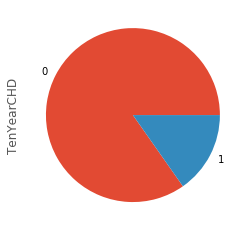

In [4]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [5]:
x = heart_df.values
scaler = MinMaxScaler()# Utilice un MinMaxScaler en esta ocasión #
x_scaled = scaler.fit_transform(x) # Aplique el escalamiento #
heart_df_scaled = pd.DataFrame(x_scaled, columns=heart_df.columns) # Conversión a un DataFrame #

In [6]:
x = heart_df_scaled.iloc[:,:-1]
y = heart_df_scaled.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)
print(x_test.shape)

(750, 14)


## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [7]:
logreg =LogisticRegression() # Modelo de Regresión Logística #
logreg.fit(x,y) # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {sklearn.metrics.accuracy_score(y_test, y_pred)}')

Precisión inicial: 0.8493333333333334


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

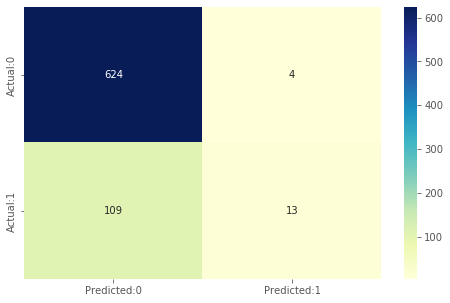

In [8]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

## <u> Análisis de Resultados </u>

Debido a que en la base de datos considerada se tienen más pacientes, aproximadamente 506 pacientes más (de 750 pacientes en total), que *no tienen riesgo* de padecer una enfermedad coronaria en 10 años (Clase 0) que pacientes que sí poseen ese riesgo (Clase 1), si hubiera un modelo de regresión logística que únicamente clasificaría a pacientes como no riesgosos de CHD, tendría una precisión de aproximadamente el $84\%$ *(véase ecuación 1)*. En otras palabras, si el modelo de regresión lógistica clasificara a cualquier paciente en la clase 0 acertaría el $84\%$ de las veces.

$$
\begin{align}
\tag{1}
Accuracy Score = \frac{628}{750} = 0.8373
\end{align}
$$

Ahora bien, como se evidencia en las celdas anteriores, la precisión del modelo implementado, a través de la función `LogisticRegression`, obtenida (0.8493) fue bastante parecida, difiere en aproximadamente $1.2\%$, a la de un modelo que únicamente clasificaría a pacientes con la clase 0. De hecho, con la matriz de confusión, mostrada en la celda anterior, se puede observar que el modelo implementado clasificó únicamente a 13 de los 109 pacientes de clase 1 correctamente. Es decir, que la mayoría de pacientes los clasificó como clase 0, comitiendo **errores de tipo II** para pacientes que realmente pertenecen a la clase 1. En contraste, el modelo únicamente clasificó erróneamente a  4 pacientes de la clase 0 como pacientes de la clase 1, **errores tipo I**. 

Por tal motivo, la precisión del modelo de regresión logísitica implementado está *sesgada* debido a que los datos están considerablemente desbalanceados hacia la clase 0. En términos sencillos, al tener una considerable cantidad mayor de pacientes pertenecientes a una clase sobre la otra, el modelo resultaría más preciso si clasifica a todos los pacientes como la clase 0, como en el presente caso de estudio. 

Para concluir, sin haber realizado un análisis para conocer cuantos datos pertenecen a ambas clases previo a implementar el modelo, se podría llegar a pensar que es un buen modelo al tener una precisión satisfactoria. Sin embargo, como fue argumentado anteriormente, el modelo implementado no tiene un buen desempeño.

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [9]:
from sklearn.preprocessing import binarize

umbrales = np.linspace(0,1,15) # Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes, threshold = umbral)[:,1]# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2)
    print(f'''------------Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}-------------------\n''')


------------Para un umbral de 0.0 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos positivos.
Sensitividad: 1.0 Especificidad: 0.0-------------------

------------Para un umbral de 0.0714 tenemos esta matriz de confusión:
[[199 429]
 [ 10 112]]
Con 311 predicciones correctas y 10 falsos positivos.
Sensitividad: 0.918 Especificidad: 0.3169-------------------

------------Para un umbral de 0.1429 tenemos esta matriz de confusión:
[[404 224]
 [ 37  85]]
Con 489 predicciones correctas y 37 falsos positivos.
Sensitividad: 0.6967 Especificidad: 0.6433-------------------

------------Para un umbral de 0.2143 tenemos esta matriz de confusión:
[[517 111]
 [ 60  62]]
Con 579 predicciones correctas y 60 falsos positivos.
Sensitividad: 0.5082 Especificidad: 0.8232-------------------

------------Para un umbral de 0.2857 tenemos esta matriz de confusión:
[[572  56]
 [ 84  38]]
Con 610 predicciones correctas y 84 falsos positivos.
Sensitividad: 0.311

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

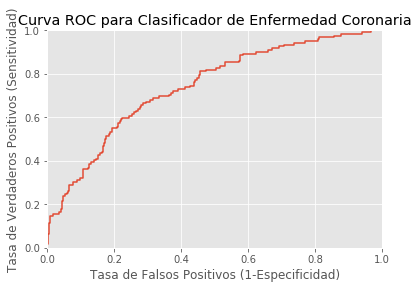

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

In [11]:
umbrales
txt = 'Los umbrales de decisión considerados fueron: \n {umbrales}'
print(txt.format(umbrales = np.round(umbrales, 2)))

Los umbrales de decisión considerados fueron: 
 [0.   0.07 0.14 0.21 0.29 0.36 0.43 0.5  0.57 0.64 0.71 0.79 0.86 0.93
 1.  ]


Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.




### <u> Análisis de Resultados </u>

Como se puede observar en la curva ROC, el modelo **no es capaz de distinguir** entre las dos clases estudiadas. Esto último es debido a que la AUC es 0.5 *(véase ecuación 2)*  y por ende, existen 2 posibilidades: que el modelo implementado elige aleatoriamente una de las dos clases (cada una con una probabilidad de 0.5) o que el modelo elige una de las clases siempre (discrimina a una clase). En cualquier de los dos casos anteriores, el modelo realmente no se esta ajustando a los datos, sino que toma una decisión de manera aleatoria. Por tanto, el modelo implementado, tiene un desempeño bajo debido, en mayor medida por el desbalance de los datos. 

$$
\begin{align}
\tag{2}
AUC = \frac{1}{2} (base * altura) = \frac{1}{2} = 0.5
\end{align}
$$


Por otro lado, es importante mencionar que en presente el caso de estudio hay un mayor impacto negativo al cometer errores de tipo II (clasificar un paciente con bajo riesgo, cuando realmente tiene alto riesgo) que errores tipo I (clasificar a un paciente con alto riesgo, cuando realmente tiene bajo riesgo). Por tal motivo, y en ese sentido, el mejor *umbral de decisión* de los considerados *(véase celda anterior)* se encuentra a partir de $0.6429$ debido a que, como se evidencia en las matrices de confusión mostradas anteriormente, la *Especifidad* siempre es 1. Sin embargo, a partir de ese umbral de decisión, se está cometiendo una mayor cantidad de errores tipo I. Esto es debido a que la Especifidad del modelo es inversamente proporcional a la Sensitividad del mismo, al aumentar el umbral de decisión. Ahora bien, si se desea encontrar un mayor balance entre la Especifidad y la Sensitividad, el mejor umbral de decisión encontrado fue de $0.2143$. Pues si bien se "sacrificó" un poco de Sensitividad, como lo encontrado en umbrales menores, dicho sacrificio no es tan drástico como el encontrado en umbrales mayores, manteniendo, además, un valor de Especifidad alto. La matriz de confusión de confusión obtenida para dicho umbral de decisión se muestra en la celda a continuación.

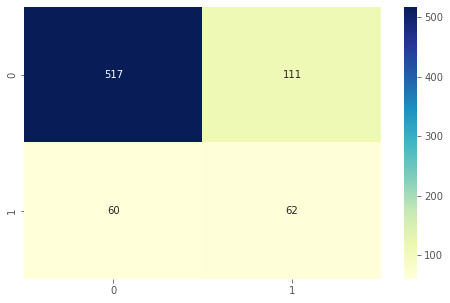

In [12]:
cm2 = 0
y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
y_pred2 = binarize(y_pred_prob_yes, threshold = 0.2143, copy=False)[:,1]# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
cm2 = confusion_matrix(y_test,y_pred2)
plt.figure(figsize = (8,5))
sn.heatmap(cm2, annot=True,fmt='d',cmap="YlGnBu")

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [13]:
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #
w = w0.copy()

# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-5
error = 100
dif = 100

def sigma(w,x):
    res_sigmoid = 1/(1 + np.exp(-np.dot(np.transpose(w),x)))# Salida de la función sigmoide #
    return res_sigmoid

tasas = np.linspace(0.0001,0.1,10) # Defina un vector que contenga las tasas que desea probar #
lista_errores = []
y_pred_list = []
for tasa in tasas:
        errores = []
        y_pred_l = []
    #while error > eps:         # Criterio de parada 1 #
        for j in range (0, 1500):  # Criterio de parada 2 #
            ## Desarrollo de algoritmo ##
                     
            # Selección del par (x,y)             
            i = np.random.randint(0, X_train_array.shape[0])
            x_i = X_train_array[i]
            y_i = y_train_array[i]
        
            # Cálculo de la predicción del modelo
            g = sigma(w, x_i)
        
            # Cálculo del error 
            error = g - y_i
            errores.append(abs(error))
        
            # Ajuste de los párametros del modelo
            w = w - tasa * error * x_i
            
        lista_errores.append(errores)
    
        X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
        y_test_array = y_test.values
    
        y_pred = np.zeros(len(x_test))
        for i in range(0,len(x_test)):
            prob = sigma(w,X_test_array[i])
            if prob > 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        
        y_pred_l.append(y_pred)
        y_pred_list.append(y_pred_l)
        print(f'Precisión modelo actual: {sklearn.metrics.accuracy_score(y_test,y_pred)}')

Precisión modelo actual: 0.16266666666666665
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8466666666666667
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8373333333333334
Precisión modelo actual: 0.8466666666666667
Precisión modelo actual: 0.8386666666666667


In [14]:
y_pred_arr = np.array(y_pred_l)
y_pred_arr_l = np.array(y_pred_list)

l1,l2,l3,l4,l5,l6,l7,l8,l9,l10 = np.vsplit(y_pred_arr_l, 10)

l1 = l1.reshape(l1.shape[1:])
l2 = l2.reshape(l2.shape[1:])
l3 = l3.reshape(l3.shape[1:])
l4 = l4.reshape(l4.shape[1:])
l5 = l5.reshape(l5.shape[1:])
l6 = l6.reshape(l6.shape[1:])
l7 = l6.reshape(l7.shape[1:])
l8 = l8.reshape(l8.shape[1:])
l9 = l9.reshape(l9.shape[1:])
l10 = l10.reshape(l10.shape[1:])

l1 = l1.transpose()
l2 = l2.transpose()
l3 = l3.transpose()
l4 = l4.transpose()
l5 = l5.transpose()
l6 = l6.transpose()
l7 = l7.transpose()
l8 = l8.transpose()
l9 = l9.transpose()
l10 = l10.transpose()

### <u> Tasas de aprendizaje ($\eta$)

Las tasas de aprendizaje que se consideraron en el presente caso de estudio se muestran en la celda a continuación. Así mismo, se gráfico la función de error vs. el número de iteraciones para cada $\eta$. Estas últimas, también, se muestran a continuación.

In [15]:
tasas

tasas_T = tasas.transpose()

df_tasas = pd.DataFrame(data = tasas_T,columns=['Tasa de Aprendizaje'])

df_tasas

,Tasa de Aprendizaje
0,0.0001
1,0.0112
2,0.0223
3,0.0334
4,0.0445
5,0.0556
6,0.0667
7,0.0778
8,0.0889
9,0.1000


####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0001

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0001) ')

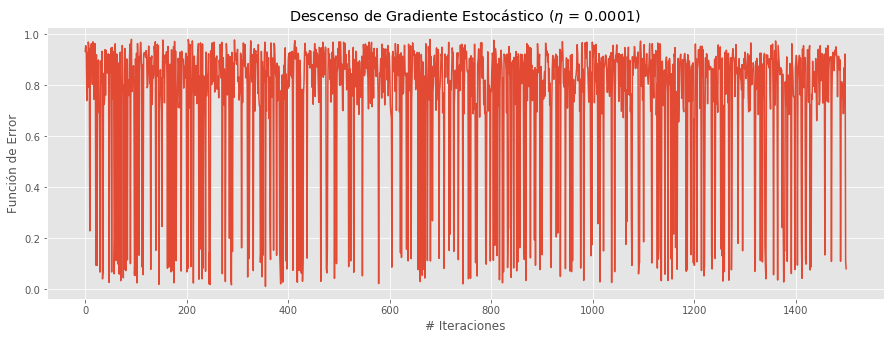

In [16]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[0])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0001) ')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0112

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0112)')

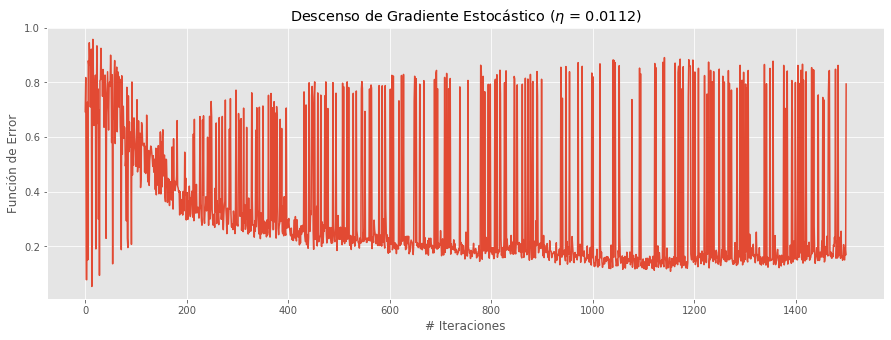

In [17]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[1])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0112)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0223

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0223)')

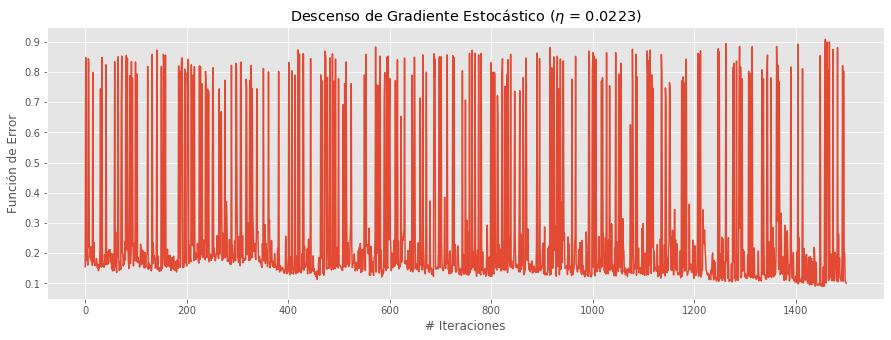

In [18]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[2])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0223)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0334

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0334)')

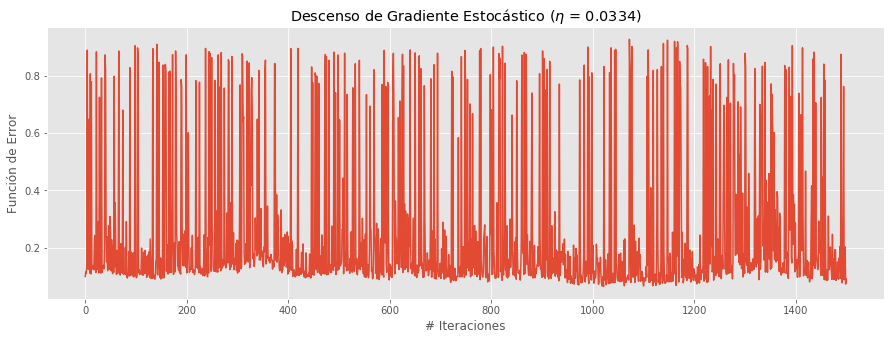

In [19]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[3])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0334)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0445

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0445)')

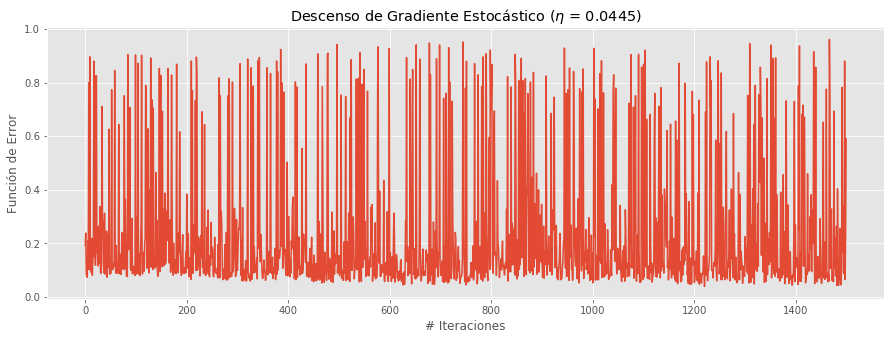

In [20]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[4])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0445)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0556

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0556)')

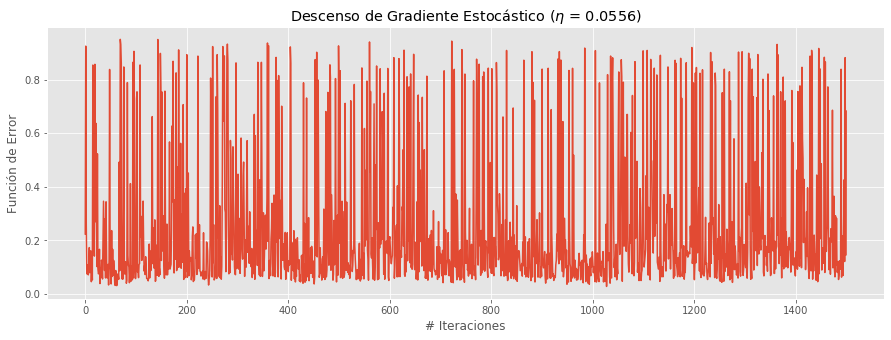

In [21]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[5])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0556)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0667

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0667)')

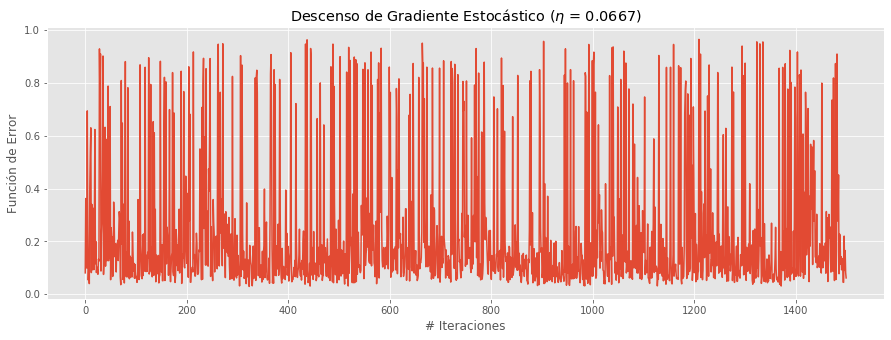

In [22]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[6])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0667)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0778

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0778)')

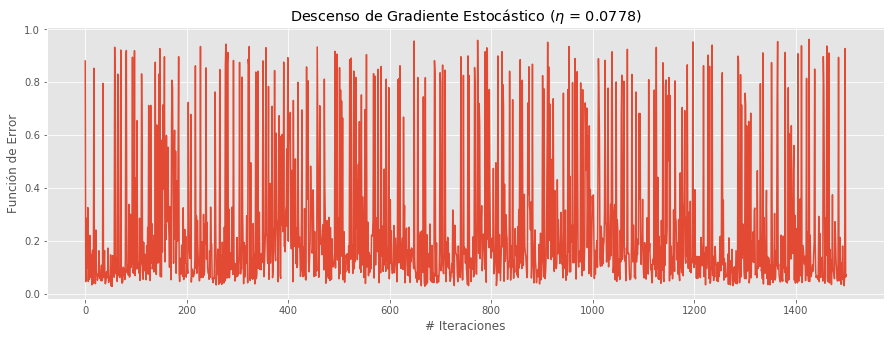

In [23]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[7])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0778)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.0889

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.0889)')

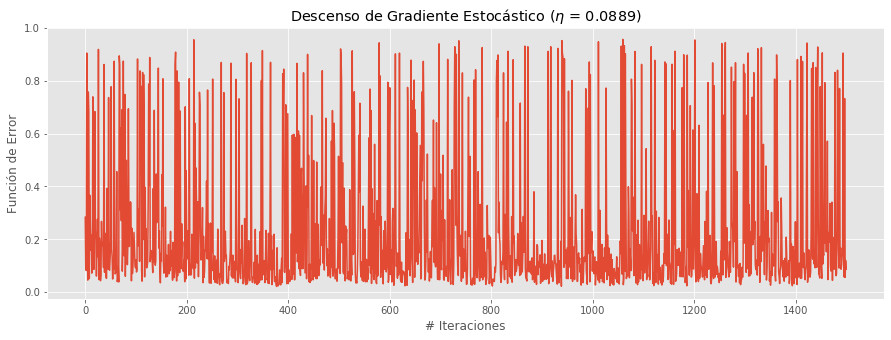

In [24]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[8])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.0889)')

####  Función de error vs. Número de Iteraciones para $\eta$ = 0.1

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico ($\\eta$ = 0.1)')

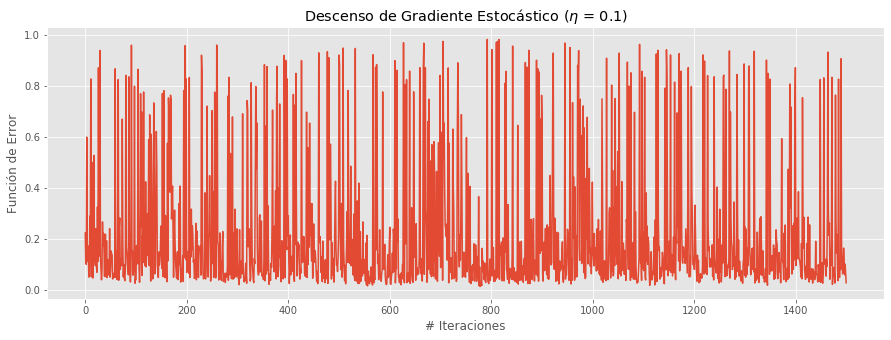

In [25]:
plt.figure(figsize=(15,5))
plt.plot(lista_errores[9])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico ($\eta$ = 0.1)')

### <u> Análisis de Resultados </u>

Como era de esperarse, la función de error en cada iteración para la mayoría de las tasas de aprendizaje consideradas (a excepción de una tasa de aprendizaje, $\eta = 0.0112$) tiene un comportamiento aleatorio. Es decir, el comportamiento de la función de error **en cada iteración** del algoritmo S.G.D, no es de "descenso": el error puede aumentar en iteraciones consecutivas y luego, descender, por ejemplo. Esto se debe, principalmente, al hecho de que se está calculando un estimativo del gradiente de la función de error, *entropía cruzada* (véase ecuación 3), con únicamente un único par $(x_i, y_i)$. En otras palabras, en cada iteración del algoritmo de Descenso de Gradiente Estócastico se esta calculando un término de la suma de la función de error *(véase ecuación 4)*. Por ende, se tiene una fuerte dependencia del par de datos elegido en cada iteración, resultando en el comportamiento observado en las gráficas mostradas anteriormente. Por otro lado, otra razón por el comportamiento obtenido de la función de error en cada iteración, en menor medida, se puede deber al hecho que el tamaño de las tasas de aprendizaje requieran un mayor número de iteraciones para llegar al mínimo. Sin embargo, debido a que únicamente se tienen 2999 datos de entrenamiento, aumentar el número de iteraciones no es recomendable.

$$
\begin{align}
\tag{3}
l(w) = - \sum_{i = 1}^{n} y_i  log(\sigma(w^T x_i)) + (1-y_i) log(1 - \sigma(w^T x_i))
\end{align}
$$


$$
\begin{align}
\tag{3}
\nabla l(w) \approx  (y_i - \sigma(w^T x_i))x_i
\end{align}
$$


Ahora bien, con base únicamente a las gráficas de *Función de Error vs. # de Iteraciones* el mejor comportamiento observado corresponde a la tasa de aprendizaje de tamaño $\eta = 0.0112$. En ella, se puede observar el comportamiento de descenso deseado del error en cada iteración, a pesar de lo mencionado anteriormente. Por otro lado, con base a la métrica de *Precisión* del modelo se obtuvo que la tasa de aprendizaje no tuvo un mayor efecto: varias tasas consideradas tuvieron la misma precisión, donde la mayor obtenida fue del $84.66\%$ para tasas de aprendizaje de tamaño $\eta = 0.0556$ y $\eta = 0.0889$. Sin embargo, debido al desbalance de los datos y la naturaleza del problema, como fue mencionado anteriormente, dicha métrica no es una medida de evaluación del modelo, en este caso partícular. Por tal motivo, a continuación se mostrarán la matriz de confusión obtenida para cada tasa de aprendizaje considerada.

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

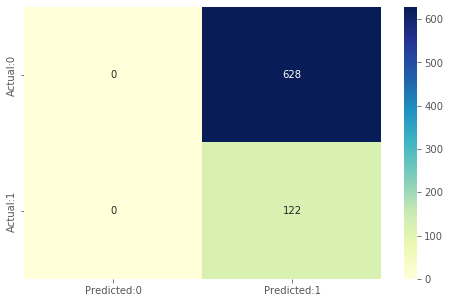

In [26]:
cm_1 = confusion_matrix(y_test,l1)
conf_matrix_1 = pd.DataFrame(data=cm_1,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_1, annot=True,fmt='d',cmap="YlGnBu")

In [27]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

precision_1 = precision_score(y_test,l1)
recall_1 = recall_score(y_test,l1)
accuracy_1 = accuracy_score(y_test,l1)
f1_score_1 = f1_score(y_test,l1)

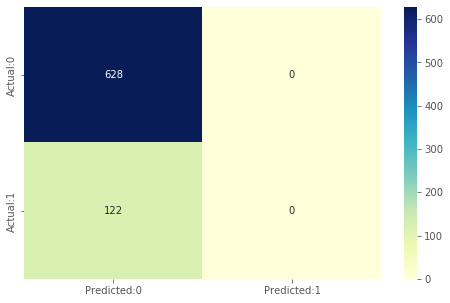

In [28]:
cm_2 = confusion_matrix(y_test,l2)
conf_matrix_2 = pd.DataFrame(data=cm_2,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_2, annot=True,fmt='d',cmap="YlGnBu")

In [29]:
precision_2 = precision_score(y_test,l2)
recall_2 = recall_score(y_test,l2)
accuracy_2 = accuracy_score(y_test,l2)
f1_score_2 = f1_score(y_test,l2)

/home/alejo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


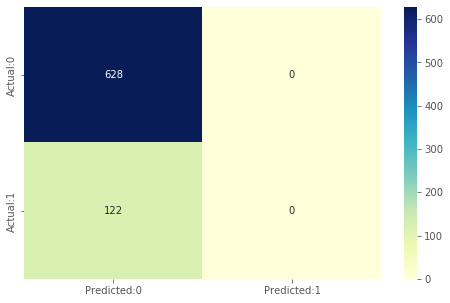

In [30]:
cm_3 = confusion_matrix(y_test,l3)
conf_matrix_3 = pd.DataFrame(data=cm_3,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_3, annot=True,fmt='d',cmap="YlGnBu")

In [31]:
precision_3 = precision_score(y_test,l3)
recall_3 = recall_score(y_test,l3)
accuracy_3 = accuracy_score(y_test,l3)
f1_score_3 = f1_score(y_test,l3)

/home/alejo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


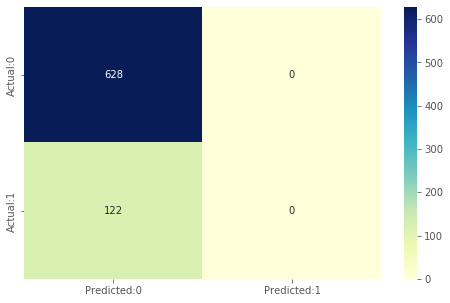

In [32]:
cm_4 = confusion_matrix(y_test,l4)
conf_matrix_4 = pd.DataFrame(data=cm_4,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_4, annot=True,fmt='d',cmap="YlGnBu")

In [33]:
precision_4 = precision_score(y_test,l4)
recall_4 = recall_score(y_test,l4)
accuracy_4 = accuracy_score(y_test,l4)
f1_score_4 = f1_score(y_test,l4)

/home/alejo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


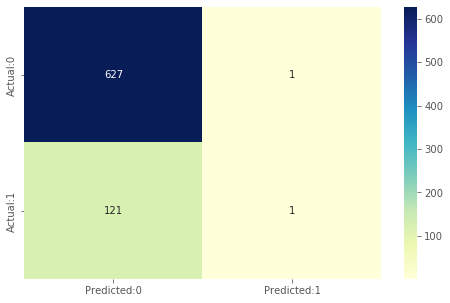

In [34]:
cm_5 = confusion_matrix(y_test,l5)
conf_matrix_5 = pd.DataFrame(data=cm_5,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_5, annot=True,fmt='d',cmap="YlGnBu")

In [35]:
precision_5 = precision_score(y_test,l5)
recall_5 = recall_score(y_test,l5)
accuracy_5 = accuracy_score(y_test,l5)
f1_score_5 = f1_score(y_test,l5)

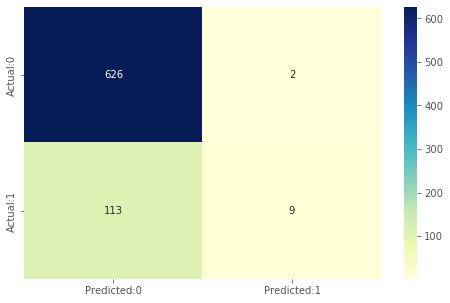

In [36]:
cm_6 = confusion_matrix(y_test,l6)
conf_matrix_6 = pd.DataFrame(data=cm_6,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_6, annot=True,fmt='d',cmap="YlGnBu")

In [37]:
precision_6 = precision_score(y_test,l6)
recall_6 = recall_score(y_test,l6)
accuracy_6 = accuracy_score(y_test,l6)
f1_score_6 = f1_score(y_test,l6)

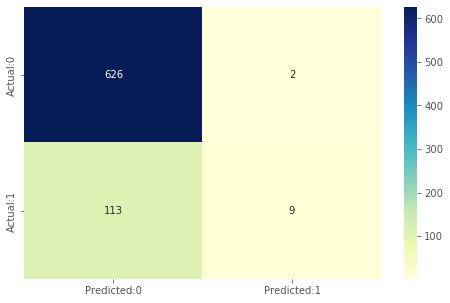

In [38]:
cm_7 = confusion_matrix(y_test,l7)
conf_matrix_7 = pd.DataFrame(data=cm_7,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_7, annot=True,fmt='d',cmap="YlGnBu")

In [39]:
precision_7 = precision_score(y_test,l7)
recall_7 = recall_score(y_test,l7)
accuracy_7 = accuracy_score(y_test,l7)
f1_score_7 = f1_score(y_test,l7)

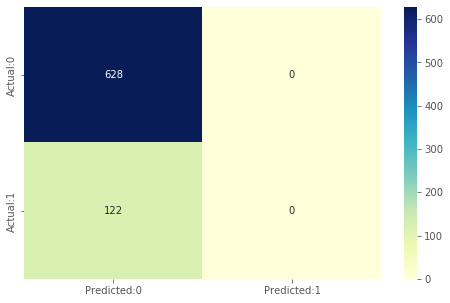

In [40]:
cm_8 = confusion_matrix(y_test,l8)
conf_matrix_8 = pd.DataFrame(data=cm_8,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_8, annot=True,fmt='d',cmap="YlGnBu")

In [41]:
precision_8 = precision_score(y_test,l8)
recall_8 = recall_score(y_test,l8)
accuracy_8 = accuracy_score(y_test,l8)
f1_score_8 = f1_score(y_test,l8)

/home/alejo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


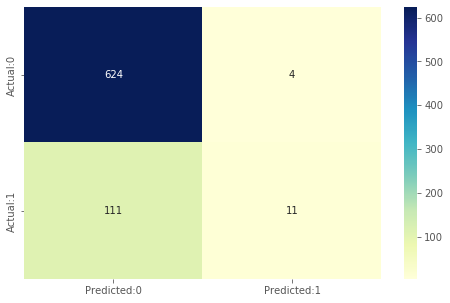

In [42]:
cm_9 = confusion_matrix(y_test,l9)
conf_matrix_9 = pd.DataFrame(data=cm_9,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_9, annot=True,fmt='d',cmap="YlGnBu")

In [43]:
precision_9 = precision_score(y_test,l9)
recall_9 = recall_score(y_test,l9)
accuracy_9 = accuracy_score(y_test,l9)
f1_score_9 = f1_score(y_test,l9)

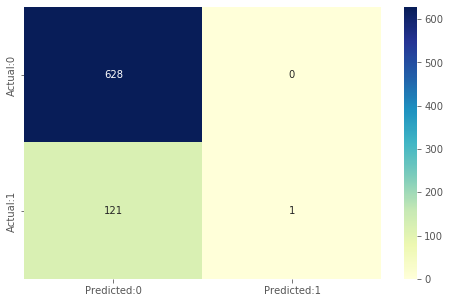

In [44]:
cm_10 = confusion_matrix(y_test,l10)
conf_matrix_10 = pd.DataFrame(data=cm_10,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix_10, annot=True,fmt='d',cmap="YlGnBu")

In [45]:
precision_10 = precision_score(y_test,l10)
recall_10 = recall_score(y_test,l10)
accuracy_10 = accuracy_score(y_test,l10)
f1_score_10 = f1_score(y_test,l10)

### <u> Análisis de Resultados </u>

Con base en los resultados presentados al generar las diferentes matrices de confusión para cada tasa de aprendizaje propuesta en este ejercicio, se observan diferentes respuestas que nos permiten inferir sobre la eficacia del clasificador planteado conforme el modelo de regresión logística utilizado. Para facilitar el análisis de los resultados de desempeño del modelo es de gran utilidad calcular y establecer métricas de precisión y exactitud del modelo como las mostradas a continuación:

$$ 
\begin{align}
\tag{1}
    \textbf{Precision} = \frac{\textbf{TP}}{\textbf{TP} + \textbf{FP}}  
\end{align}
$$

La primera métrica para analizar es la de exactitud (Precisión), la cual nos permite relacionar los aciertos positivos con los desaciertos positivos del modelo utilizado, esta métrica está más asociada a los errores tipo 1 que ocurren cuando el modelo infiere o predice de valores positivos para datos falsos, lo que se conoce como falsos positivos. 


$$ 
\begin{align}
\tag{2}
    \textbf{Recall} = \frac{\textbf{TP}}{\textbf{TP} + \textbf{FN}}  
\end{align}
$$

Por otro lado, otra métrica que se suele evaluar es la métrica de recordar (Recall), esta métrica relaciona los aciertos positivos con los desaciertos negativos y permite inferir sobre los resultados de falsos negativos determinados por el modelo utilizado, a su vez está asociada a los errores tipo 2 de clasificación en donde el modelo infiere o predice valores negativos para datos verdaderos. 

$$ 
\begin{align}
\tag{3}
    \textbf{Accuracy} = \frac{\textbf{TP} + \textbf{TN}}{\textbf{TP} + \textbf{TN} + \textbf{FP} + \textbf{FN}}  
\end{align}
$$

De la misma manera se puede definir la métrica de precisión (Accuracy) que permite evaluar el modelo de clasificación relacionando el número total de predicciones correctas sobre el número total de predicciones realizadas por el modelo. Esta métrica es muy útil para evaluar de manera general la capacidad de predicción del modelo.

$$ 
\begin{align}
\tag{4}
    \textbf{F1} = \frac{2*\textbf{Precision} * \textbf{Recall}}{\textbf{Precision} + \textbf{Recall}}   
\end{align}
$$

Existen otras métricas como la métrica de puntuación (F1 Score) que permite relacionar la capacidad de predicción del modelo de clasificación a la hora de tratar con datos que siguen un comportamiento desequilibrado o desbalanceado.

In [46]:
df

NameError: name 'df' is not defined

In [ ]:
precision_r = np.array([precision_1, precision_2, precision_3, precision_4, precision_5, precision_6, precision_7, precision_8, precision_9, precision_10])
recall_r = np.array([recall_1, recall_2, recall_3, recall_4, recall_5, recall_6, recall_7, recall_8, recall_9, recall_10])
accuracy_r = np.array([accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7, accuracy_8, accuracy_9, accuracy_10])
f1_score_r = np.array([f1_score_1, f1_score_2, f1_score_3, f1_score_4, f1_score_5, f1_score_6, f1_score_7, f1_score_8, f1_score_9, f1_score_10])

results = np.array([[precision_1, recall_1, accuracy_1, f1_score_1], 
                    [precision_2, recall_2, accuracy_2, f1_score_2],
                    [precision_3, recall_3, accuracy_3, f1_score_3],
                    [precision_4, recall_4, accuracy_4, f1_score_4],
                    [precision_5, recall_5, accuracy_5, f1_score_5],
                    [precision_6, recall_6, accuracy_6, f1_score_6],
                    [precision_7, recall_7, accuracy_7, f1_score_7],
                    [precision_8, recall_8, accuracy_8, f1_score_8],
                    [precision_9, recall_9, accuracy_9, f1_score_9],
                    [precision_10, recall_10, accuracy_10, f1_score_10]])

results_df = pd.DataFrame(data = results , columns=['Precision','Recall','Accuracy', 'F1 Score'])

df = df_tasas.join(results_df, how='left', on=None)

fig = plt.figure()

plt.plot(tasas, precision_r, 'b-o')
plt.plot(tasas, recall_r, 'r-o')
plt.plot(tasas, accuracy_r, 'g-o')
plt.plot(tasas, f1_score_r, 'y-o')
plt.axis([0, 0.1, 0, 1])
plt.legend(['Precision', 'Recall', 'Accuracy', 'F1 Score'], facecolor='white', framealpha=1, loc = 'best')
plt.xlabel('Tasa de aprendizaje')
plt.ylabel('Valor indicador')
plt.title('Resultados de precisión, exactitud, recuperación y puntuación')

plt.show()

A partir de los resultados presentados en la anterior tabla y gráfica se puede observar que a excepción de la menor tasa de aprendizaje utilizada para todas las demás se obtiene un valor favorable de precisión del modelo. No obstante, se observa que las métricas de exactitud y recuerdo varían en menor y mayor medida de una tasa de aprendizaje a otra, encontrando mejores resultados para tazas de aprendizaje intermedias en el rango de evaluación propuesto. Además, observando los valores de la métrica de recuerdo (Recall) en los resultados arrojados por el modelo de clasificación utilizado es posible concluir que este no es muy bueno para predecir valores verdaderos y positivos correctamente (baja sensibilidad del modelo).

Con base en lo anterior es posible inferir que en gran parte los resultados corresponden al grado de desequilibrio de los datos de entrenamiento del modelo. 